In [1]:
import os  
import tensorflow as tf  
from tensorflow.keras.preprocessing.image import ImageDataGenerator  
from tensorflow.keras.preprocessing import image  
import numpy as np  
import matplotlib.pyplot as plt  

# Setting up directories for training data  
base_dir = 'dataset/training'  

train_good_dir = os.path.join(base_dir, 'good')  
train_anomaly_dir = os.path.join(base_dir, 'anomaly')  
  
# Image dimensions and batch size  
img_width, img_height = 256, 256  # Change according to your dataset  
batch_size = 32
  
# Data preparation  
train_datagen = ImageDataGenerator(  
    rescale=1./255,  # Rescale the pixel values to [0, 1]  
    rotation_range=40,  
    width_shift_range=0.2,  
    height_shift_range=0.2,  
    shear_range=0.2,  
    zoom_range=0.2,  
    horizontal_flip=True,  
    fill_mode='nearest',  
    validation_split=0.2  # Use 20% of the images as the validation set  
)  
  
train_generator = train_datagen.flow_from_directory(  
    base_dir,  
    target_size=(img_width, img_height),  
    batch_size=batch_size,  
    class_mode='binary',  # Because we're doing binary classification  
    subset='training'  
)  
  
validation_generator = train_datagen.flow_from_directory(  
    base_dir,  
    target_size=(img_width, img_height),  
    batch_size=batch_size,  
    class_mode='binary',  # Because we're doing binary classification  
    subset='validation'  
)  
  
# CNN model architecture  
model = tf.keras.models.Sequential([  
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(img_width, img_height, 3)),  
    tf.keras.layers.MaxPooling2D(2, 2),  
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),  
    tf.keras.layers.MaxPooling2D(2, 2),  
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),  
    tf.keras.layers.MaxPooling2D(2, 2),  
    tf.keras.layers.Flatten(),  
    tf.keras.layers.Dense(512, activation='relu'),  
    tf.keras.layers.Dense(1, activation='sigmoid')  # Sigmoid function because it's a binary classification  
])  
  
# Compiling the model  
model.compile(optimizer='adam',  
              loss='binary_crossentropy',  # Since it's binary classification  
              metrics=['accuracy'])  
  
# Model summary  
model.summary()  
  

Found 43 images belonging to 2 classes.
Found 10 images belonging to 2 classes.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 128)       73856     
                                          

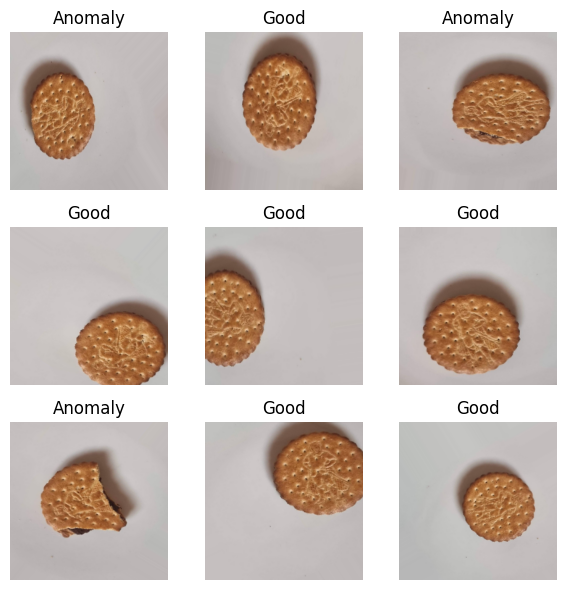

In [2]:
def plot_images_from_generator(generator, num_images=8):  
    """
    This function plots a series of images returned by an ImageDataGenerator.  
      
    Parameters:  
    - generator: The ImageDataGenerator instance to plot images from.  
    - num_images: Number of images to display.  
    """
      
    # Get a batch of images  
    imgs, labels = next(generator)  # 'next' retrieves the next batch  
      
    # Determine the grid size needed  
    nrows = int(num_images ** 0.5)  
    ncols = int(np.ceil(num_images / nrows))  
      
    # Set up matplotlib fig, and size it to fit `num_images` images  
    plt.figure(figsize=(6, 6))  
    for i in range(num_images):  
        plt.subplot(nrows, ncols, i + 1)  
        # Rescale images to display them correctly  
        img = imgs[i] * 255  # Assuming the generator rescales images by 1/255  
        plt.imshow(img.astype(np.uint8))
        
        if labels[i] == 1:  
            plt.title('Good')  
        else:  
            plt.title('Anomaly')  
        plt.axis('off')  
    plt.tight_layout()  
    plt.show()  
  
# Assumes 'train_generator' is already instantiated as per the previous example  
plot_images_from_generator(train_generator, num_images=9)  

In [3]:
# Training  
history = model.fit(  
    train_generator,  
    validation_data=validation_generator,  
    epochs=30  # Number of epochs to train the model. An epoch is an iteration over the entire x and y data provided.  
)  

Epoch 1/30
2/2 [==============================] - 3s 1s/step - loss: 2.0247 - accuracy: 0.4419 - val_loss: 3.7185 - val_accuracy: 0.7000
Epoch 2/30
2/2 [==============================] - 3s 2s/step - loss: 1.0261 - accuracy: 0.7209 - val_loss: 0.9289 - val_accuracy: 0.3000
Epoch 3/30
2/2 [==============================] - 3s 2s/step - loss: 0.8028 - accuracy: 0.2791 - val_loss: 0.6702 - val_accuracy: 0.7000
Epoch 4/30
2/2 [==============================] - 3s 2s/step - loss: 0.6513 - accuracy: 0.7209 - val_loss: 0.6291 - val_accuracy: 0.7000
Epoch 5/30
2/2 [==============================] - 3s 2s/step - loss: 0.5945 - accuracy: 0.7209 - val_loss: 0.6556 - val_accuracy: 0.7000
Epoch 6/30
2/2 [==============================] - 3s 2s/step - loss: 0.7418 - accuracy: 0.7209 - val_loss: 0.6985 - val_accuracy: 0.7000
Epoch 7/30
2/2 [==============================] - 3s 969ms/step - loss: 0.6972 - accuracy: 0.7209 - val_loss: 0.6102 - val_accuracy: 0.7000
Epoch 8/30
2/2 [======================

1/1 [==============================] - 0s 36ms/step


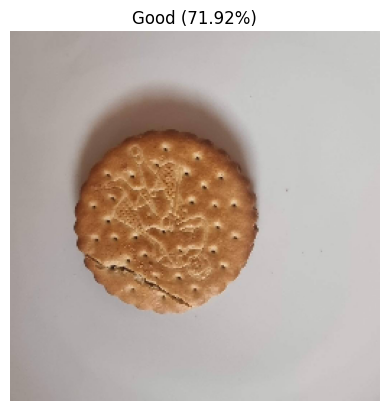

1/1 [==============================] - 0s 37ms/step


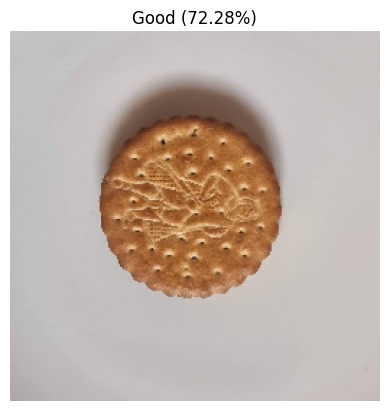

In [5]:
def predict_and_display_image(image_path, model):  
    # Loading and preprocessing image  
    img = image.load_img(image_path, target_size=(img_width, img_height))  
    img_array = image.img_to_array(img)  
    img_array = np.expand_dims(img_array, axis=0)  # Create a batch  
    img_array /= 255.0  # Rescale image values to [0, 1]  
  
    # Make prediction  
    prediction = model.predict(img_array)  
    prediction_score = prediction[0]  
      
    # Since it's a binary classification, determine the class based on the score  
    if prediction_score < 0.5:  
        class_prediction = 'Anomaly'  
        score = (1 - prediction_score[0]) * 100  
    else:  
        class_prediction = 'Good'  
        score = prediction_score[0] * 100  
  
    # Displaying the image  
    plt.imshow(img)  
    plt.axis('off')  # Don't show axes for images  
    plt.title(f'{class_prediction} ({score:.2f}%)')  
    plt.show()  
  
predict_and_display_image("test/anomaly.jpg", model)  
predict_and_display_image("test/good.jpg", model)  
